In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pylhe
import pandas as pd

In [2]:
defaultPars = {'figure.figsize': (5, 4),
               'lines.markersize' : 4,
               'axes.titlesize' : 13,
               'font.size' : 13,
               'axes.labelsize' : 16,
               'xtick.labelsize' : 13,
               'ytick.labelsize' : 13,
               'legend.fontsize' : 10,
               "text.usetex": True,
               "font.family": "sans-serif",
               "font.sans-serif": ["Helvetica"],
               'font.family':'Times New Roman', 
               'font.serif':'Times New Roman',
               "savefig.dpi" : 300,
               'contour.linewidth' : 2.0,
               'lines.linewidth' : 2.0,
               'axes.grid' : True,
               'grid.linewidth' : 0.5,
               'grid.color' : 'lightgray',
               'axes.axisbelow' : True
               }
plt.rcParams.update(defaultPars)

In [3]:
def boost_particle(beta,ptc):
    
    beta = np.array(beta)
    b = np.linalg.norm(beta)
    v4 = np.insert(beta,0,1)

    four_mom = np.array([ptc.e,ptc.px,ptc.py,ptc.pz])

    if b == 0:
        return ptc

    if b > 1.0:
        print('Beta larger than 1!!')
        return ptc

    g = 1/np.sqrt(1 - b**2)

    # Lorentz transformation matrix

    Ce = np.einsum("i,j->ij", beta, beta)*(g**2/(1+g)) + np.identity(3)
    L = g*beta
    C = g*v4
    D = np.insert(Ce, 0, L, axis=0)
    M = np.insert(D, 0, C, axis=1)

    new_four_mom = np.round(np.dot(four_mom, M),8)

    pDict = {k : val for k,val in ptc.__dict__.items() if k not in ['event']}
    new_ptc = pylhe.LHEParticle(**pDict)
    new_ptc.e = new_four_mom[0]
    new_ptc.px = new_four_mom[1]
    new_ptc.py = new_four_mom[2]
    new_ptc.pz = new_four_mom[3]

    return new_ptc

def add(ptcList,**kwargs):
    pDict = {'id' : 0, 'status' : 1, "mother1" : -1, "mother2" : -1, "color1" : 0, "color2": 0, "m" : -1, "lifetime" : -1, "spin" : -1}
    for attr in ['e','px','py','pz']:
        pDict[attr] =  sum([getattr(ptc,attr) for ptc in ptcList])

    ptcTot = pylhe.LHEParticle(**pDict)
    ptcTot.m = np.sqrt(np.round(ptcTot.e**2 - ptcTot.px**2 - ptcTot.py**2 - ptcTot.pz**2,3))
    for k,v in kwargs.items():
        setattr(ptcTot,k,v)

    return ptcTot

def getSd(photons,chi0s):       
    sd = add(photons+chi0s,id=55)
    return sd

def getchi1s(photons,chi0s):

    # Try both combinations
    chi1p = add([chi0 for chi0 in chi0s if chi0.id >0]+[photons[0]],id=5000023)
    chi1m = add([chi0 for chi0 in chi0s if chi0.id < 0]+[photons[1]],id=-5000023)

    chi1p_b = add([chi0 for chi0 in chi0s if chi0.id >0]+[photons[1]],id=5000023)
    chi1m_b = add([chi0 for chi0 in chi0s if chi0.id < 0]+[photons[0]],id=-5000023)

    if abs(chi1p.m-chi1m.m) > abs(chi1p_b.m-chi1m_b.m):
        return [chi1p_b,chi1m_b]
    else:
        return [chi1p,chi1m]
    


In [4]:
files = {
         'without spin corr.' : './pp2Sd/Events/run_01_decayed_1/unweighted_events.lhe.gz',
        #  'with spin corr.' : './pp2Sd/Events/run_01_decayed_2/unweighted_events.lhe.gz',
         'full' : './pp2chi0chi0/Events/run_01/unweighted_events.lhe.gz',
         }


pT = {}
eta = {}
dR = {}
cols = ['label',r'$\eta(\chi_1 (1))$',r'$\eta(\chi_1 (2))$',
                r'$\phi(\chi_1 (1))$',r'$\phi(\chi_1 (2))$',
                r'$\eta(\chi_0 (1))$',r'$\eta(\chi_0 (2))$',
                r'$\phi(\chi_0 (1))$',r'$\phi(\chi_0 (2))$',
                r'$m(S)$ (GeV)',r'$m(\chi_1 (1))$ (GeV)',r'$m(\chi_1 (2))$ (GeV)',
                r'$m(\chi_0 (1))$ (GeV)',r'$m(\chi_0 (2))$ (GeV)'
        ]

nmax = -1
dataList = []
for label,f in files.items():
    ievt = 0
    for event in pylhe.read_lhe_with_attributes(f):
        ievt += 1
        if nmax > 0 and ievt > nmax:
            break
        photons = [ptc for ptc in event.particles if abs(ptc.id) == 22]
        chi0s = [ptc for ptc in event.particles if abs(ptc.id) == 5000022]
        chi1s = [ptc for ptc in event.particles if abs(ptc.id) == 5000023]
        ss = [ptc for ptc in event.particles if abs(ptc.id) == 55]

        if len(photons) != 2:
            print(f'{len(photons)} photons found in {f}!')
            for ptc in event.particles:
                print(' ',ptc.id,ptc.m)
            break
        if len(chi0s) != 2:
            print(f'{len(chi0s)} chi0 found in {f}!')
            for ptc in event.particles:
                print(' ',ptc.id,ptc.m)
            break

        if len(chi1s) != 2:
            chi1s = getchi1s(photons,chi0s)
        if len(ss) != 2:
            ss = [getSd(photons,chi0s)]


        s = ss[0]
        s_beta = np.array([s.px,s.py,s.pz])/s.e
        chi1s_CM = [boost_particle(-s_beta,chi1) for chi1 in chi1s]
        chip = [chi1 for chi1 in chi1s if chi1.id > 0][0]
        chim = [chi1 for chi1 in chi1s if chi1.id < 0][0]
        chi1p_beta = np.array([chip.px,chip.py,chip.pz])/chip.e
        chi1m_beta = np.array([chim.px,chim.py,chim.pz])/chim.e

        chi0p = [chi0 for chi0 in chi0s if chi0.id > 0][0]
        chi0m = [chi0 for chi0 in chi0s if chi0.id < 0][0]
        chi0s_CM = [boost_particle(-chi1p_beta,chi0p),boost_particle(-chi1m_beta,chi0m)]
        
        for p in photons+chi0s+chi1s+chi1s_CM+chi0s_CM:
            p.pT = np.sqrt(p.px**2 + p.py**2)
            p.eta = (1./2.)*np.log((p.e+p.pz)/(p.e-p.pz))
            p.phi = np.arctan2(p.py,p.px)
            m0sq = np.round(p.e**2 - p.px**2 - p.py**2 - p.pz**2,3)
            if m0sq < 0.0:
                print(m0sq,p.id)
            p.m0 = np.sqrt(m0sq) # Round number in case of small numerical differences

        data = [label,
                chi1s_CM[0].eta,chi1s_CM[1].eta,chi1s_CM[0].phi,chi1s_CM[1].phi,
                chi0s_CM[0].eta,chi0s_CM[1].eta,chi0s_CM[0].phi,chi0s_CM[1].phi,
                s.m,chi1s[0].m,chi1s[1].m,chi0s[0].m,chi0s[1].m
                ]
        dataList.append(data)

df = pd.DataFrame(columns=cols,data=dataList)
        

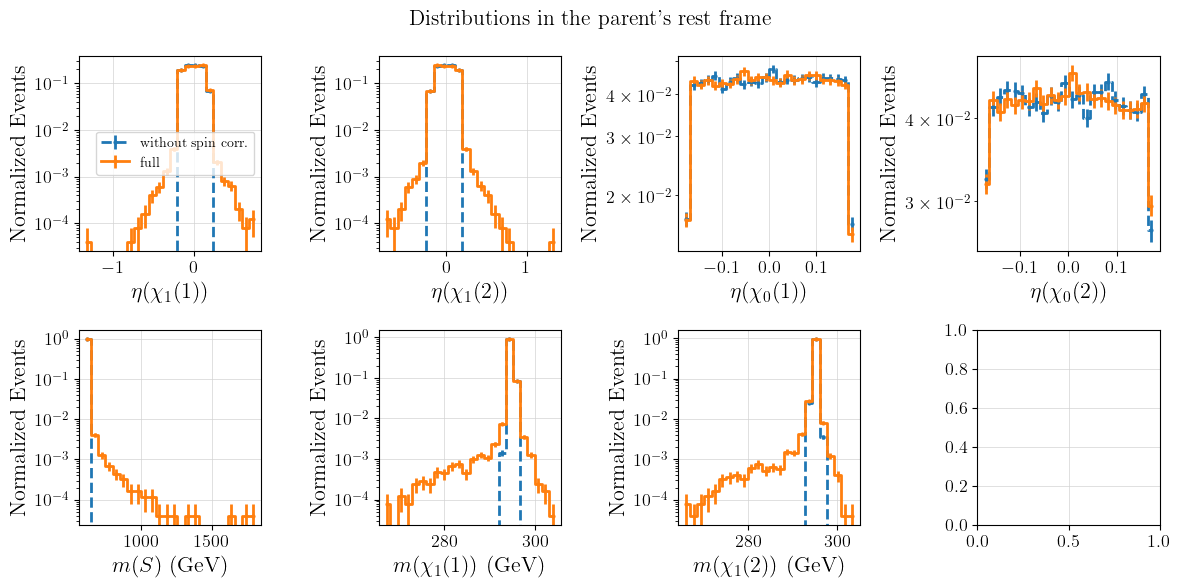

In [7]:
plot_variables = [c for c in df.columns if c not in ['label']]
plot_variables = [c for c in plot_variables[:] if 'phi' not in c]
plot_variables = [c for c in plot_variables[:] if r'm(\chi_0' not in c]


ncols = 4
nrows = int((len(plot_variables)-1)/ncols)
while nrows*ncols < len(plot_variables):
    nrows += 1
fig,axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(3*ncols,3*nrows))
axarr = np.array(axes).reshape(-1)




for i,var in enumerate(plot_variables):
    v_max, v_min = df[var].max(),df[var].min()
    bins = np.linspace(v_min,v_max,25)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax = axarr[i]
    ymax = 0.0
    for label in df['label'].unique():
        if 'full' in label:
            ls = 'solid'
        else:
            ls = 'dashed'
        data = df[df['label'] == label]
        y,_ = np.histogram(data[var], bins=bins)
        yerr = np.sqrt(y)
        norm = sum(y)
        y = y/norm
        ymax = max(ymax,y.max())
        yerr = yerr/norm
        ax.errorbar(bin_centers,y,yerr = yerr,marker = '.',drawstyle = 'steps-mid',
                 label=label,linewidth=2,linestyle=ls)
    ax.set_xlabel(var)
    ax.set_ylabel('Normalized Events')
    if i == 0:
        ax.legend()
    # ax.set_ylim(0.0,1.1*ymax)
    ax.set_yscale('log')
fig.suptitle("Distributions in the parent's rest frame")
plt.tight_layout()
plt.show()

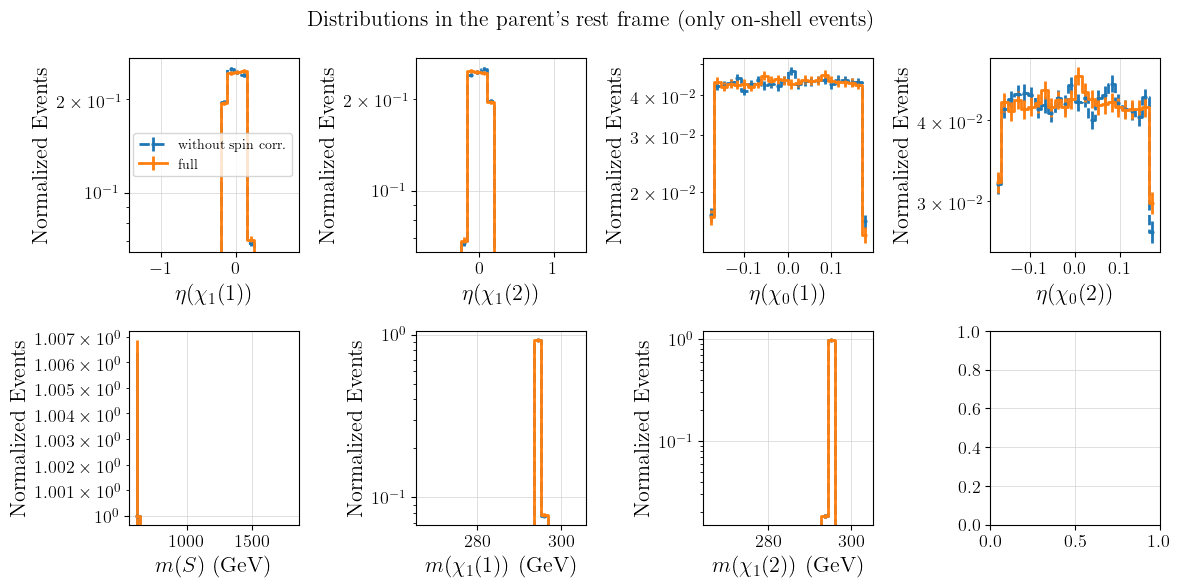

In [8]:
plot_variables = [c for c in df.columns if c not in ['label']]
plot_variables = [c for c in plot_variables[:] if 'phi' not in c]
plot_variables = [c for c in plot_variables[:] if r'm(\chi_0' not in c]


ncols = 4
nrows = int((len(plot_variables)-1)/ncols)
while nrows*ncols < len(plot_variables):
    nrows += 1
fig,axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(3*ncols,3*nrows))
axarr = np.array(axes).reshape(-1)



for i,var in enumerate(plot_variables):
    v_max, v_min = df[var].max(),df[var].min()
    bins = np.linspace(v_min,v_max,25)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax = axarr[i]
    ymax = 0.0
    for label in df['label'].unique():
        if 'full' in label:
            ls = 'solid'
        else:
            ls = 'dashed'
        data = df[df['label'] == label]
        ## Filter for on-shell events:
        data = data.loc[np.abs(df[r'$m(\chi_1 (1))$ (GeV)']-df[r'$m(\chi_1 (1))$ (GeV)'].mean()) < 1.0]
        data = data.loc[np.abs(df[r'$m(\chi_1 (2))$ (GeV)']-df[r'$m(\chi_1 (2))$ (GeV)'].mean()) < 1.0]
        data = data.loc[np.abs(df[r'$m(S)$ (GeV)']-df[r'$m(S)$ (GeV)'].mean()) < 1.0]
        y,_ = np.histogram(data[var], bins=bins)
        yerr = np.sqrt(y)
        norm = sum(y)
        y = y/norm
        ymax = max(ymax,y.max())
        yerr = yerr/norm
        ax.errorbar(bin_centers,y,yerr = yerr,marker = '.',drawstyle = 'steps-mid',
                 label=label,linewidth=2,linestyle=ls)
    ax.set_xlabel(var)
    ax.set_ylabel('Normalized Events')
    if i == 0:
        ax.legend()
    # ax.set_ylim(0.0,1.1*ymax)
    ax.set_yscale('log')
fig.suptitle("Distributions in the parent's rest frame (only on-shell events)")
plt.tight_layout()
plt.show()